In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from PIL import Image
from numpy import linalg as LA
from sklearn.decomposition import PCA

In [2]:
# Read and prepare data
raw_data = pd.read_csv('./data.csv')
raw_data['filepath'] = './' + raw_data['filepath']

## Sort images into different emotions

In [3]:
# Any neat way for this kind of mapping? 
fe = []
ha = []
sa = []
ne = []
su = []
for i, j in raw_data.iterrows():
    filepath = j['filepath']
    im = Image.open(filepath)
    im = np.array(im)
    expression = j['facial_expression']
    if (expression == 'fear'):
        fe.append(im)
    elif (expression == 'happiness'):
        ha.append(im)
    elif (expression == 'sadness'):
        sa.append(im)
    elif (expression == 'neutral'):
        ne.append(im)
    elif (expression == 'surprise'):
        su.append(im)
fe = np.array(fe)
ha = np.array(ha)
sa = np.array(sa)
ne = np.array(ne)
su = np.array(su)
ha.shape

(31, 256, 256)

## Only work with one emotion for now

(256, 256, 31)


Text(0.5, 0.98, 'Happy faces')

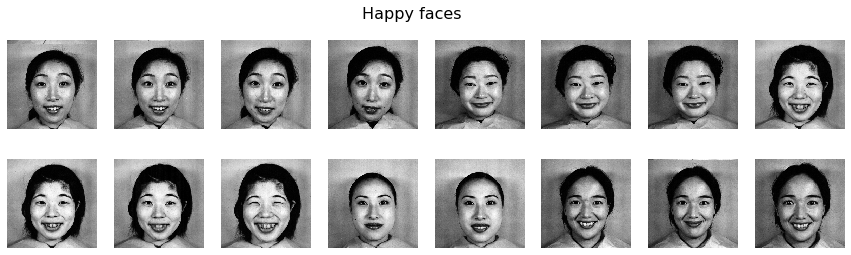

In [4]:
images = ha
images = images.transpose(1,2,0)
images = images/255
print(images.shape)
fig = plt.figure(figsize=(15,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(images[:,:,i],cmap = 'gray')
    plt.axis('off')
plt.suptitle('Happy faces', size = 16)

## PCA theory
The input images can be seen as a vector.  
The idea of PCA is that since all the faces have some similarity, we want to express the information in these faces more efficiently. Therefore we want to find a new set of faces, where all the original faces can be expressed as a linear combination of those new faces. In this new set of faces, most information are included in the first few images.  
First, denote the size of the images as $N\times N$, denote the number of images as $M$.  
Denote the flattened original images as $\Gamma_{1},...,\Gamma_{M}$. They have dimension $N^2\times 1$.  
Denote the average face as $\Psi$, where $$\Psi = \frac{1}{M}\sum_{n=1}^{M}\Gamma_{n}$$
Compute the difference between original data and the average:
$$\Phi_{i} =\Gamma_{i}-\Psi $$
Next, compute covariance matrix $C$:
$$C = AA^T$$
where $A = [\Phi_{1} \Phi_{2} ... \Phi_{M}]$
The eigenvectors of C can be found by eigenvalue decomposition on C. However, C is very large so it's not feasible to compute EVD on it.  
Instead, consider another matrix $L = A^TA$. We can show that L and C have same eigenvalues and closely related eigenvectors:  
Denote the eigenvectors of L as $v_{i}$, eigenvalues as $\mu_{i}$. Then:
$$A^TAv_{i} =\mu_{i}v_{i}  $$
$$AA^T(Av_{i}) =\mu_{i}(Av_{i})  $$
Therefore, $Av_{i}$ are eigenvectors of $C = AA^T$  
The eigenfaces can then be computed by $$U = AV$$,
where $$V = [v_{1}  v_{2} ... v_{M}]$$  
Finally, reshape each eigenvectors in $U$ to 2-D to get the eigenface images

## PCA from scratch

In [5]:
M = images.shape[2] # Number of samples
N = images.shape[0] # Dimension of data

(-0.5, 255.5, 255.5, -0.5)

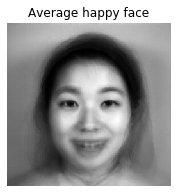

In [6]:
mean = np.mean(images, axis = 2)
plt.figure(figsize=(3,3))
plt.imshow(mean, cmap = 'gray')
plt.title('Average happy face')
plt.axis('off')

In [7]:
demeaned = images - mean[...,None] # Subtract average face from all faces. Use broadcasting

Text(0.5, 0.98, 'After subtracting average face')

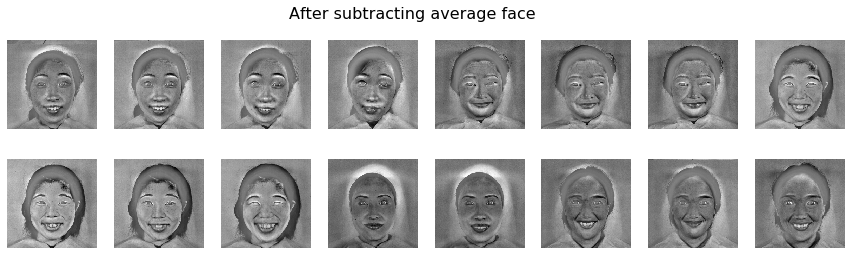

In [8]:
fig = plt.figure(figsize=(15,4))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(demeaned[:,:,i],cmap = 'gray')
    plt.axis('off')
plt.suptitle('After subtracting average face',size=16)

In [9]:
A = np.zeros((N*N, M)) #(65536, 31)
for i in range(M):
    A[:,i] = demeaned[:,:,i].flatten()
#C = np.matmul(A, A.transpose())

In [10]:
L = np.matmul(A.transpose(), A)

In [11]:
mu, v = LA.eig(L) # Find eig of A^TA
idx = mu.argsort()[::-1]
mu = mu[idx]
v = v[:,idx]

In [12]:
u = np.matmul(A, v) # Construct eigenvectors of AA^T

In [13]:
eigfaces = np.zeros((N,N,M))
for i in range(M):
    eigfaces[:,:,i] = u[:,i].reshape(N,N)

Text(0.5, 0.98, 'All eigenfaces, from scratch')

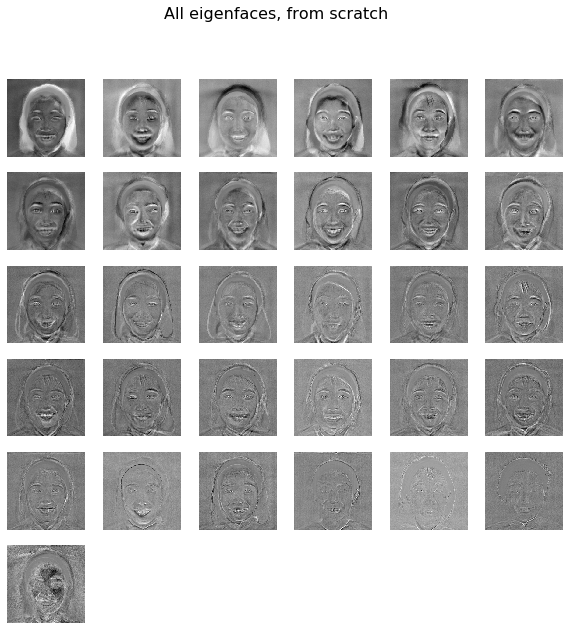

In [14]:
# Plot eigenfaces
fig = plt.figure(figsize=(10, 10))
for i in range(M):
    plt.subplot(6,6,i+1)
    plt.imshow(eigfaces[:,:,i],cmap = 'gray')
    plt.axis('off')
plt.suptitle('All eigenfaces, from scratch',size=16)

## PCA with sklearn

In [15]:
faces = pd.DataFrame([])
for i in range(M):
    faces = faces.append(pd.Series(images[:,:,i].flatten()), ignore_index = True)
faces_pca = PCA(n_components=31, svd_solver='randomized',whiten=True).fit(faces)

Text(0.5, 0.98, 'All eigenfaces with sklearn')

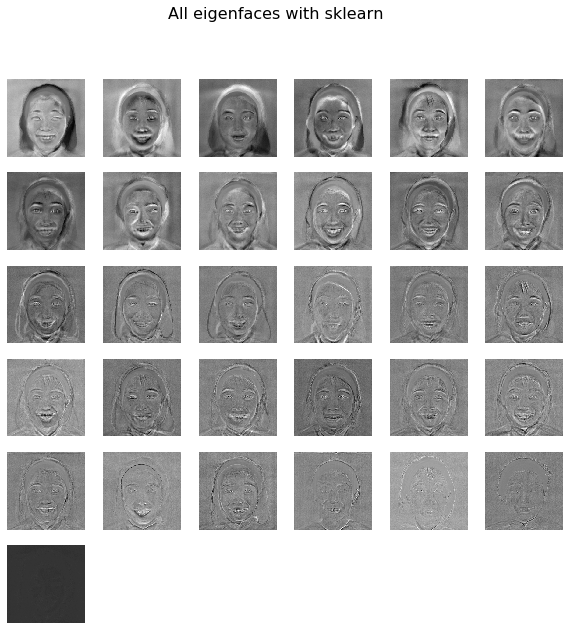

In [16]:
fig = plt.figure(figsize=(10, 10))
for i in range(M):
    plt.subplot(6,6,i+1)
    plt.imshow(faces_pca.components_[i].reshape(N,N),cmap='gray')
    plt.axis('off')
plt.suptitle('All eigenfaces with sklearn',size=16)

## Results comparison
By plotting the eigenfaces, we can see that from scratch and sklearn methods have same output eigenfaces. Some looks different because they differ in sign.

Text(0.5, 1.0, 'From scratch')

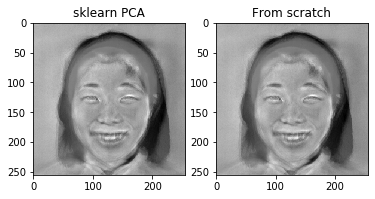

In [17]:
idx = 0
plt.subplot(121)
plt.imshow(faces_pca.components_[idx].reshape(N,N),cmap='gray')
plt.title('sklearn PCA')
plt.subplot(122)
plt.imshow(-eigfaces[:,:,idx],cmap = 'gray')
plt.title('From scratch')

$\frac{1}{2}$